In [ ]:
#!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/boneage-test-dataset/boneage-test-dataset/"))

# Any results you write to the current directory are saved as output.

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

from __future__ import print_function, division
import skimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader

from skimage import io, transform





In [56]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        df['path'] = df['id'].map(lambda x: os.path.join(img_dir,
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
        #df['exists'] = df['path'].map(os.path.exists) 
        df['gender'] = df['male'].map(lambda x: 1 if x else 0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['id'].values
        self.y = df['boneage']
        self.gender = df['gender']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      str(self.img_names[index])+'.png'))

        #img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        img = np.asarray(img)
        #img = transform.resize(np.asarray(img), (384, 384))
        #img = np.transpose(img, (1, 2, 0))
        img = skimage.transform.resize(img, (3,299, 299)) 
        #img = torch.from_numpy(img)
        
        #label = self.y[index]
        #label = torch.from_numpy(np.asarray(self.y[index]))
        label = self.y.values[index].astype('float')

        gender = self.gender.values[index]
        sample = {'image': img, 'gender':gender, 'label': label}
        
        return sample

    def __len__(self):
        return self.y.shape[0]
    
    def print_bok(self):
      print(self.y)

In [57]:
# class ImgAugTransform:
#   def __init__(self):
#     self.aug = iaa.Sequential([
#         iaa.Scale((224, 224)),
#         iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
#         iaa.Fliplr(0.5),
#         iaa.Affine(rotate=(-20, 20), mode='symmetric'),
#         iaa.Sometimes(0.25,
#                       iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
#                                  iaa.CoarseDropout(0.1, size_percent=0.5)])),
#         iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
#     ])
      
#   def __call__(self, img):
#     img = np.array(img)
#     return self.aug.augment_image(img)

# transforms = ImgAugTransform()

#dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)



# data_transforms = transforms.Compose([transforms.ColorJitter(brightness=.05, contrast=.05, saturation=.05, hue=.05),
#                                       transforms.RandomHorizontalFlip(p=0.5),
#                                       transforms.RandomVerticalFlip(p=0.5),
#                                       transforms.RandomRotation(30),
#                                       #transforms.Grayscale(),                                       
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5), (0.5, 0.5))])


data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

In [58]:
# from PIL import Image
# import numpy as np

# def load_image( infilename ) :
#     img = Image.open( infilename )
#     img.load()
#     data = np.asarray( img, dtype="int32" )
#     return data
# img = Image.open('../input/boneage-training-dataset/boneage-training-dataset/7851.png')

# #img = img.convert('RGB')
# img = np.asarray(img)
# type(img)

# img = skimage.transform.resize(img, (299, 299))
# img = torch.from_numpy(img)

# print(img.shape)
# plt.imshow(img)

In [59]:
full_dataset = CelebaDataset(csv_path='../input/boneage-training-dataset.csv',
                                    img_dir='../input/boneage-training-dataset/boneage-training-dataset/', transform=data_transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


In [60]:
#img= face_dataset.__getitem__(0)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


torch.Size([16])


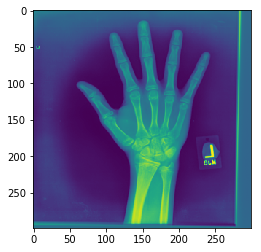

In [61]:
# Get a batch of training data
bone = next(iter(val_data_loader))
#print('Batch shape:',imgs.numpy().shape)
#print(bone['image'].numpy()[0,0,:,:].shape)
imgs = bone['image']
plt.imshow(imgs[0,0,:,:])
#print(gender)
print(bone['label'].shape)
#print(imgs)

In [62]:
# imgs = np.transpose(imgs,(0,3,1,2))
# imgs.shape

In [63]:
import torch.nn.functional as F

class BoneAgeModel(nn.Module):
    def __init__(self):
        super(BoneAgeModel, self).__init__()
        # added one layer before the inceptionv3 model to reshape the inputs. (b,3,500,500)-->(b,1,500,500)
        self.cnn = models.inception_v3(pretrained=False, aux_logits=False)
#         first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
#         first_conv_layer.extend(list(self.cnn.features))  
#         self.cnn.features= nn.Sequential(*first_conv_layer )  
#         self.cnn.fc = nn.Linear(
#             self.cnn.fc.in_features, 228)
 
        self.lin_layer = nn.Linear(1, 32)
        self.fc1 = nn.Linear(1000+32, 1000)
        self.fc2 = nn.Linear(1000, 228)
        
    def forward(self, image, gender):
        x1 = self.cnn(image)
        x2 = F.relu(self.lin_layer(gender))
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

model = BoneAgeModel()
model.cuda()

# batch_size = 20
# image = torch.randn(batch_size, 3, 299, 299)
# data = torch.randn(batch_size, 1)

# output = model(image, data)
# data.shape

BoneAgeModel(
  (cnn): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (

In [70]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
#age_predictor = age_predictor.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.5)





In [71]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def eval_model(model,data_loader):
    model.eval()

    with torch.no_grad():
        
        result_array = np.array([])
        
        for batch_no,batch in enumerate(data_loader):
            
            optimizer.zero_grad()
            
            image = batch['image'].to(device)
            gender = batch['gender'].to(device,dtype=torch.int64)
            
    
            outputs = model(image,gender)
            preds = outputs.cpu().numpy()
    
            preds = preds.reshape(preds.shape[0])
            preds = denormalize(preds,age_min,age_max)
            
            result_array = np.concatenate((result_array,preds))
            
        return result_array

In [72]:
# Training Loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    for epoch in range(num_epochs):
        scheduler.step()
        model.train()
        running_loss = 0.0
        val_running_loss = 0.0
        
        for batch_no,batch in enumerate(train_loader):
            # Load batch
            image = batch['image'].to(device)
            gender = batch['gender'].to(device)
            age = batch['label'].to(device)

            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                # Forward Pass
                outputs = model(image,gender)
                loss = criterion(outputs, age)
                
                # Backprop
                loss.backward()
                optimizer.step()
                
            # Calculate Loss
            running_loss += loss.item() * image.size(0)
            
            if (batch_no + 1) % 25 == 0: print('Epoch {} Batch {}/2500 '.format(epoch+1,batch_no+1))
            
        total_loss = running_loss / dataset_size
        print('\n \n Epoch {} Loss: {:.4f} \n \n'.format(epoch+1,total_loss))
        
        
    # Eval on validation set
    model.eval()
    for val_batch in val_data_loader:
        image = val_batch['image'].to(device)
        gender = val_batch['gender'].to(device)
        age = val_batch['label'].to(device)

        
        optimizer.zero_grad()  
        # only forward pass, dont update gradients
        with torch.set_grad_enabled(False):
            outputs = model(image,gender)
            loss = criterion(outputs, age)
            
        val_running_loss += loss.item() * image.size(0)
    
    val_loss = val_running_loss / 1611
    
    print('Validation Loss {:.4f}'.format(val_loss))
        
        
        
        
    # Save checkpoint every epoch
    total_epochs = scheduler.state_dict()['last_epoch'] + 1        
    states = {
            'epoch': total_epochs + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'scheduler'  : scheduler.state_dict()
        }
    save_checkpoint(states,filename = 'epoch-{}-loss-{:.4f}-val_loss-{:.4f}.pth.tar'.format(total_epochs,total_loss,val_loss))

    return model


In [73]:
resnet_model = train_model(model,criterion,optimizer,scheduler,num_epochs=20)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'mat2'

In [ ]:
from torch.autograd import Variable
losses = [];
for epoch in range(2):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(image, data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

In [ ]:
img_dir='../input/boneage-test-dataset/boneage-test-dataset/'
df = pd.read_csv('../input/boneage-test-dataset.csv')
# df['path'] = df['id'].map(lambda x: os.path.join(img_dir,
#                                                          'boneage-training-dataset', 
#                                                          '{}.png'.format(x)))
# len(df)
# img = Image.open(os.path.join(img_dir,
#                                       str(1377)+'.png'))


In [ ]:
#torch.from_numpy(np.asarray(img))
#df = df.drop(['path'],axis=1)
#df['male'].head()
np.min(df['boneage'])

In [ ]:
type(df.values)
#torch.from_numpy(np.asarray(df).reshape([1,1]))
#df.head()
df.values
label = torch.from_numpy(df.values[2].astype('int'))
#df.values[2]
label


In [ ]:
df.values[2].astype('int')

In [ ]:
# Get a batch of training data
imgs, steering_angle = next(iter(train_loader))
print('Batch shape:',imgs.numpy().shape)
#plt.imshow(imgs.numpy())
#plt.show()
#plt.imshow(imgs.numpy())
#plt.show()

import torchvision.transforms as transforms



# type(imgs)
# pilTrans = transforms.ToPILImage()
# #pilImg = pilTrans(imgs)
# imgplot = plt.imshow(imgs)




In [ ]:
data_transforms = transforms.Compose([transforms.Resize(384),
                                    transforms.Grayscale(),                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    #print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

# from torchvision import models
# inputs = torch.randn(1,3,224,224)
# resnet18 = models.resnet18()
# y = resnet18(Variable(inputs))
# print(y)
x1 = torch.randn(1, 19, 9, 96)
x2 = torch.randn(1, 9, 22)    
target = torch.randint(0, 2, (1,))
criterion = nn.CrossEntropyLoss()

g = make_dot(model(image,data), params=dict(model.named_parameters()))
g